# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from demeter.utils.bspline import field2D_bspline
import demeter.utils.torchbox as tb
import demeter.utils.reproducing_kernels as rk
import demeter.metamorphosis as mt


def centered_square_image(size, square_size, n_per_edge=10):
    """
    Create a 2D torch image with a centered white square on a black background,
    and return landmarks evenly distributed along the square edges.

    Parameters
    ----------
    size : int | Tuple[int, int]
        Size of the image (height, width).
    square_size : int
        Side length of the centered white square.
    n_per_edge : int, optional
        Number of landmarks per edge (default: 10).

    Returns
    -------
    img : torch.Tensor
        Tensor of shape (1, 1, H, W), float32, with values in [0, 1].
    landmarks : torch.Tensor
        Tensor of shape (N, 2), where N = 4 * n_per_edge,
        containing (y, x) coordinates of landmarks along the square border.
    """
    # Handle scalar size
    if isinstance(size, int):
        size = (size, size)

    H, W = size
    img = torch.zeros((H, W), dtype=torch.float32)

    # Centered square bounds
    y_start = (H - square_size) // 2
    y_end = y_start + square_size
    x_start = (W - square_size) // 2
    x_end = x_start + square_size

    # Draw white square
    img[y_start:y_end, x_start:x_end] = 1.0

    # --- Compute landmarks along the square edges ---
    # Generate evenly spaced coordinates (excluding the last to avoid duplication)
    xs = torch.linspace(x_start, x_end, n_per_edge)
    ys = torch.linspace(y_start, y_end, n_per_edge)

    top = torch.stack([torch.full_like(xs, y_start, dtype=torch.float32), xs], dim=1)
    bottom = torch.stack([torch.full_like(xs, y_end, dtype=torch.float32), xs], dim=1)
    left = torch.stack([ys, torch.full_like(ys, x_start, dtype=torch.float32)], dim=1)
    right = torch.stack([ys, torch.full_like(ys, x_end, dtype=torch.float32)], dim=1)

    # Concatenate edges and remove duplicate corners
    landmarks = torch.cat([top, right, bottom.flip(0), left.flip(0)], dim=0).unique(dim=0)

    return img[None, None], landmarks

def random_deformation(img,  seed = 13438843606751305139, plot = True):
    if seed:
        torch.manual_seed(seed)
    cms = torch.rand((2,10,10)) -.5 * .25
    cms[0] = 0
    # cms[0,3:6,3:6] = 0
    field_true =field2D_bspline(cms, img.shape[2:],degree = (2,2),dim_stack = -1)[None]
    # field_true *= torch.tensor([0,1])
    id_grid = tb.make_regular_grid(field_true.shape, dx_convention="2square")
    deform_true = id_grid + field_true

    target = tb.imgDeform(img, deform_true)
    if plot:
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(target[0,0], cmap='gray')
        tb.gridDef_plot_2d(deform_true,ax=ax[1], step = 10)
        ax[2].imshow(
            tb.imCmp(img, target, method="seg")[0]
        )
        plt.show()
    return target, deform_true

def plot(self):
    affine = self.mp.get_rigidor()
    deform = self.mp.get_deformation()
    deform = self.mp.get_rigid(deform)

    img_rot = tb.imgDeform(self.mp.image.to('cpu'),affine,dx_convention='2square')
    source_rt = tb.imgDeform(self.source.to('cpu'),affine,dx_convention='2square')
    srt = tb.imCmp(source_rt,self.target,method = 'compose')
    irt = tb.imCmp(img_rot,self.target,method = 'compose')
    kwargs = {"origin": "lower", 'cmap': "gray"}

    fig,ax = plt.subplots(3,3, constrained_layout=True)
    ax[0,0].imshow(self.source[0,0], **kwargs)
    ax[0,0].set_title("source")

    ax[0,1].imshow(self.target[0,0], **kwargs)
    ax[0,1].set_title("target")

    tb.gridDef_plot_2d(self.id_grid, step = 40, ax = ax[0,2], color = None, alpha = .4)

    tb.gridDef_plot_2d(deform, step = 40, ax = ax[0,2])

    ax[1,0].imshow(self.mp.image.to('cpu')[0,0], **kwargs)
    ax[1,0].set_title("image deformed")

    ax[1,1].imshow(img_rot[0,0], **kwargs)

    ax[1,2].imshow(source_rt[0,0], **kwargs)
    ax[1,2].set_title("source affne")

    ax[2,1].imshow(irt[0], **kwargs)
    ax[2,1].set_title("registered vs Target")
    ax[2,2].imshow(srt[0], **kwargs)
    ax[2,2].set_title("source affine vs Target")

saves_overview.csv


torch.Size([1, 1, 200, 200])
torch.Size([28, 2])
tensor([[ 60.0000,  60.0000],
        [ 60.0000,  71.4286],
        [ 60.0000,  82.8571],
        [ 60.0000,  94.2857],
        [ 60.0000, 105.7143]])


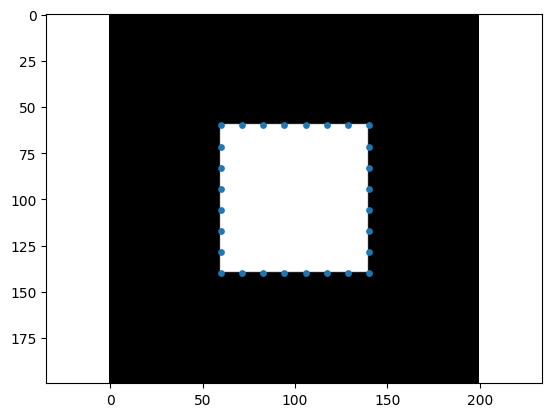

In [2]:
size = (200,200)
source, landmarks = centered_square_image(size, 80, n_per_edge=8)

print(source.shape)        # (1, 1, 128, 128)
print(landmarks.shape)  # (N, 2)
print(landmarks[:5])    # First few (y, x) coordinates

plt.imshow(source[0,0], cmap='gray')
plt.scatter(landmarks[:,1], landmarks[:,0], s=15)
plt.axis('equal'); plt.show()

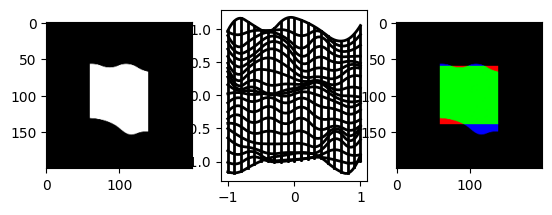

In [3]:
def random_deformation(img,  seed = 13438843606751305139, plot = True):
    if seed:
        torch.manual_seed(seed)
    else:
        print("torch seed: {seed}".format(seed=seed))
    cms = torch.rand((2,10,10)) -.5
    cms[0] = 0
    # cms[0,3:6,3:6] = 0
    field_true =field2D_bspline(cms, img.shape[2:],degree = (2,2),dim_stack = -1)[None] * .5
    # field_true *= torch.tensor([0,1])
    id_grid = tb.make_regular_grid(field_true.shape, dx_convention="2square")
    deform_true = id_grid + field_true

    target = tb.imgDeform(img, deform_true)
    if plot:
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(target[0,0], cmap='gray')
        tb.gridDef_plot_2d(deform_true,ax=ax[1], step = 10)
        ax[2].imshow(
            tb.imCmp(img, target, method="seg")[0]
        )
        plt.show()
    return target, deform_true

target_diffeo, deform_true= random_deformation(source, plot = True, seed = 3027582988843704351)

# target_diffeo, deform_true, land_deformed = random_deformation(source, landmarks, plot = True)


In [15]:
torch.seed()

3027582988843704351

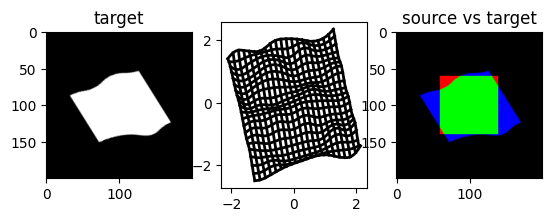

In [4]:
theta = torch.pi /7
a,b,s1, s2 = (.01, -.02, 1.3, 1.01)
# theta, a, b, s1, s2 = 0, 0,0,1,1
affine = tb.create_affine_mat_2d(torch.tensor([theta, a, b, s1, s2]))
aff_grid = tb.affine_to_grid_3d(affine, size)
target = tb.imgDeform(target_diffeo, aff_grid)



fig, ax = plt.subplots(1,3)
ax[0].imshow(target[0,0], cmap='gray')
ax[0].set_title("target")
tb.gridDef_plot_2d(deform_true + aff_grid,ax=ax[1], step = 10)
ax[2].imshow(
    tb.imCmp(source, target, method="seg")[0]
)
ax[2].set_title("source vs target")
plt.show()

#  des mots
## recherche rigide

In [ ]:
import demeter.utils.rigid_exploration as rg
integration_steps = 7

kernelOperator = rk.DummyKernel()

datacost = mt.Rotation_Ssd_Cost(source.to('cuda:0'), alpha=1)
# datacost = mt.Rotation_MutualInformation_Cost(target_b.to('cuda:0'), alpha=1)

mr_rigid = mt.rigid_along_metamorphosis(
    target, source, momenta_ini=0,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = integration_steps,
    optimizer_method='LBFGS_torch',
    cost_cst=.1,
    n_iter=0
)

top_params = rg.initial_exploration(mr_rigid,r_step=10, max_output = 10, verbose=False)
print(top_params)

best_loss, best_momenta, best_rot = rg.optimize_on_rigid(
    mr_rigid, top_params, n_iter=10,verbose=True, plot = True,
)

best_momenta : {'rot_prior': tensor([[ 0.0000,  1.0567],
        [-1.0567,  0.0000]]), 'trans_prior': tensor([ 0.3337, -0.0113]), 'scale_prior': tensor([-0.2440, -0.0791])}
rot prior : tensor([[ 0.0000,  1.0567],
        [-1.0567,  0.0000]]) 2
best_momenta : {'rot_prior': tensor([[ 0.0000,  1.0567],
        [-1.0567,  0.0000]]), 'trans_prior': tensor([ 0.3337, -0.0113]), 'scale_prior': tensor([-0.2440, -0.0791])}
momenta : {'momentum_R': tensor([[ 0.0000,  1.0567],
        [-1.0567,  0.0000]]), 'momentum_T': tensor([ 0.3337, -0.0113]), 'momentum_S': tensor([-0.2440, -0.0791])}


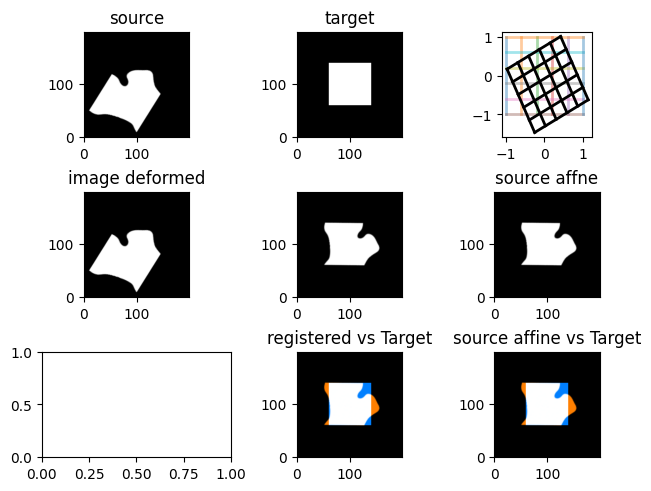

In [6]:
# Check the rigid optimisation
print(f"best_momenta : {best_momenta}")
param = best_momenta.copy()
momenta = mt.prepare_momenta(
    source.shape,
    diffeo = False,
    device = "cpu",
    requires_grad = False,
    **param
)
print(f"best_momenta : {best_momenta}")

print(f"momenta : {momenta}")

mr_rigid.mp.forward(target, momenta.copy(), save =  True)

plot(mr_rigid)
plt.show()

## rigid along lddmm

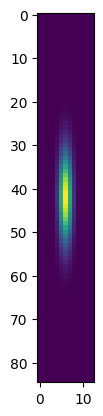

rot prior : tensor([0.]) 1
momenta type <class 'dict'>
Rotation_Ssd_Cost, iter : 0: gamma = 1.0
		data_loss : tensor(1252.5771, device='cuda:0')
		norm_v_2 : tensor(0., device='cuda:0')
		norm_l2_on_z : tensor(0., device='cuda:0')
		norm_l2_on_R : tensor(0., device='cuda:0')
		norm_S_2 : tensor(0., device='cuda:0')
Rotation_Ssd_Cost, iter : 1: gamma = 0.95
Rotation_Ssd_Cost, iter : 1: gamma = 0.95
Rotation_Ssd_Cost, iter : 1: gamma = 0.95
Rotation_Ssd_Cost, iter : 1: gamma = 0.95
Rotation_Ssd_Cost, iter : 1: gamma = 0.95
Integration diverged : Stop.


[Tensor.rigid_along_metamorphosis] 
	Max Allocated: 50.70 MB | Max Reserved: 70.00 MB


AttributeError: 'str' object has no attribute 'detach'

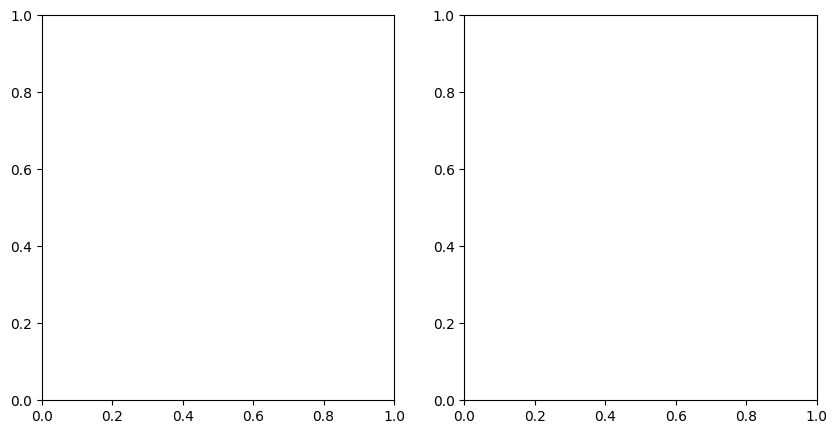

In [11]:
gamma = .5  # constante de Rotation_ssd_cost
integration_steps = 7
rho = 1
cost_cst = 1000
cst_field = 1e-4


sigma = (7,1)
kernelOperator = rk.GaussianRKHS(sigma, normalized=False, kernel_reach =6)
# print(kernelOperator.kernel[0,40])
plt.figure()
plt.imshow(kernelOperator.kernel[0])
plt.show()

# sigma = [(7,0), (15,0)]
# kernelOperator = rk.Multi_scale_GaussianRKHS(sigma, normalized=False, kernel_reach =6)
datacost = mt.Rotation_Ssd_Cost(target.to("cuda:0"), gamma=gamma, start_gamma=1, n_at_gamma_reach= 10)


# best_loss = torch.inf
# for i,param in enumerate(top_param_rot):
#     print(f"\n\noptimistion {i} on  {len(top_param_rot)}")
momenta = mt.prepare_momenta(
    source.shape,
    rotation=True,scaling=True,translation=True,
    diffeo=True,
    # **best_momenta
)
# momenta["momentum_R"].requires_grad = False
# momenta["momentum_S"].requires_grad = False
# momenta["momentum_T"].requires_grad = False


mr = mt.rigid_along_metamorphosis(
  source, target, momenta_ini=momenta,
  kernelOperator= kernelOperator,
  rho = rho,
  data_term=datacost ,
  integration_steps = integration_steps,
  cost_cst=cost_cst,
  cst_field=cst_field,
  n_iter=20,
    grad_coef=.1,
    # optimizer_method='Adam',
  save_gpu_memory=False,
  lbfgs_max_iter = 40,
  lbfgs_history_size = 20,
    safe_mode=True
)
best = False
mr.plot_cost()
plt.show()

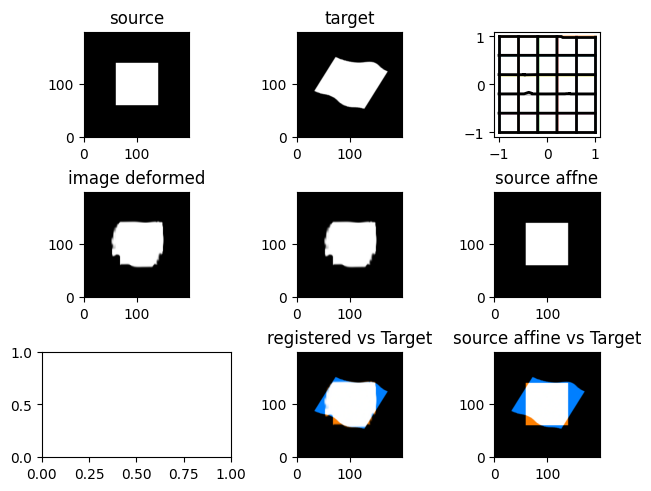

In [9]:
plot(mr)
plt.show()

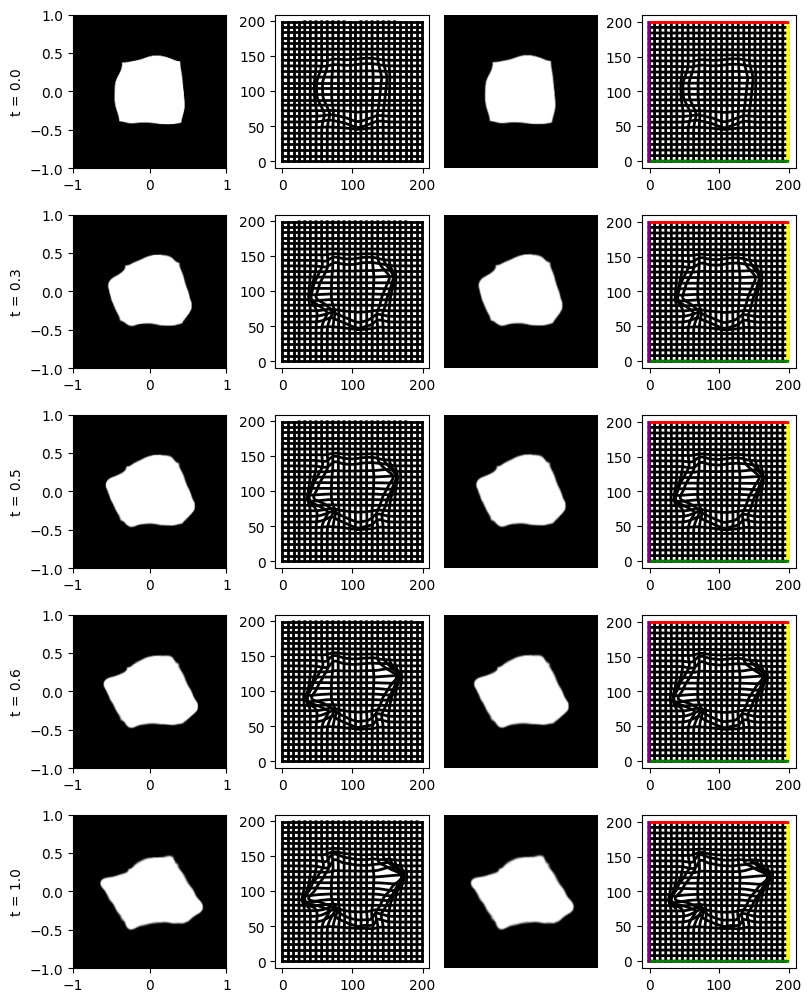

In [7]:
n_figs = 5
plot_id = (
    torch.quantile(
        torch.arange(mr.mp.image_stock.shape[0], dtype=torch.float),
        torch.linspace(0, 1, n_figs),
    )
    .round()
    .int()
)

kw_image_args = dict(
    cmap="gray", extent=[-1, 1, -1, 1], vmin=0, vmax=1
)
# v_abs_max = (mr.mp.residuals_stock.abs().max()).max()
# v_abs_max = torch.quantile(mr.mp.momenta.abs(), 0.99)
momentum =  mr.mp.momenta['momentum_I']
v_abs_max = torch.quantile(momentum.abs(), 0.99)
kw_residuals_args = dict(
    cmap="RdYlBu_r",
    extent=[-1, 1, -1, 1],
    origin="lower",
    vmin=-v_abs_max,
    vmax=v_abs_max,
)
color = "green"
size_fig = 2
# C = self.momentum_stock.shape[1]
fig, ax = plt.subplots(
    n_figs,
    4,
    constrained_layout=True,
    figsize=(size_fig * 4, n_figs * size_fig),
)
for i, t in enumerate(plot_id):
    deform = mr.mp.get_deformation(to_t = t + 1)

    i_s = ax[i, 0].imshow(
        mr.mp.image_stock[t, 0, :, :].detach().numpy(),
        **kw_image_args,
    )
    ax[i, 0].set_ylabel("t = " + str((t / (mr.mp.n_step - 1)).item())[:3])
    # fig.colorbar(i_s, ax=ax[i, 0], fraction=0.046, pad=0.04)

    tb.gridDef_plot_2d(
        deform,
        add_grid=False,
        ax=ax[i, 1],
        step=int(min(mr.mp.field_stock.shape[2:-1]) / 25),
        check_diffeo=False,
        dx_convention=mr.mp.dx_convention,
        # color = color
    )

    deform = mr.mp.get_rigid(deform)
    img = tb.imgDeform(
        mr.mp.image_stock[t, :, :, :][None],
        mr.mp.get_rigidor()
    ).detach().numpy()[0,0]

    ax[i, 2].imshow(img, **kw_image_args,)
    # ax[i, 2].set_title("t = " + str((t / (mr.mp.n_step - 1)).item())[:3])
    ax[i, 2].axis("off")

    # ax[i, 3].imshow(torch.rand((10,10)), **kw_image_args,)
    # ax[i, 3].set_title("t = " + str((t / (mr.mp.n_step - 1)).item())[:3])
    # ax[i, 3].axis("off")
    # # fig.colorbar(i_s, ax=ax[i, 0], fraction=0.046, pad=0.04)

    #
    tb.gridDef_plot_2d(
        deform,
        add_grid=False,
        add_markers=True,
        ax=ax[i, 3],
        step=int(min(mr.mp.field_stock.shape[2:-1]) / 25),
        check_diffeo=False,
        dx_convention=mr.mp.dx_convention,
    )


# set_ticks_off(ax)
plt.show()
